# Credit Card Approval Classification
This notebook explores KNN and Decision Tree classifiers using the UCI Credit Approval dataset.


Introduction

This project applies machine learning techniques to the Credit Approval dataset.  
The dataset contains 654 records with 10 predictor variables (continuous and binary) and one target variable (`R1`), which indicates whether a credit application was approved or rejected.

Objective
The main goal is to:
1. Explore the dataset structure and variables.
2. Separate predictors (`A1`–`A15`) and target (`R1`).
3. Apply two classification algorithms:
   - K-Nearest Neighbors (KNN)
   - Decision Tree
4. Evaluate both models using:
   - Cross-validation
   - Train/validation/test split
   - Performance metrics (accuracy, precision, recall, F1 score)

## 1.imports & settings

In [5]:
# Imports & config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay)
RANDOM_STATE = 42
DATA_PATH = r"D:\Projects\Baacumen\ML-Week2-Project\dataset\credit_card_data-headers.txt"
np.random.seed(RANDOM_STATE)

## 2.load & quick EDA

In [6]:
# Load dataset (file has headers)
df = pd.read_csv(DATA_PATH, sep='\t', engine='python')  # tab-separated per uploaded file
# Some versions may be whitespace-separated; if read fails use sep=r'\s+'
df = df.dropna(axis=1, how='all')  # drop empty cols
# Convert to numeric where possible
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna().reset_index(drop=True)

# Rename target column if it's R1
if 'R1' in df.columns:
    df = df.rename(columns={'R1':'target'})
else:
    df = df.rename(columns={df.columns[-1]:'target'})

print("Dataset shape:", df.shape)
display(df.head())
display(df.describe().T)
print("Target distribution:\n", df['target'].value_counts())

Dataset shape: (654, 11)


,A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,target
0,1,30.83,0.000,1.25,1,0,1,1,202,0,1
1,0,58.67,4.460,3.04,1,0,6,1,43,560,1
2,0,24.50,0.500,1.50,1,1,0,1,280,824,1
3,1,27.83,1.540,3.75,1,0,5,0,100,3,1
4,1,20.17,5.625,1.71,1,1,0,1,120,0,1


,count,mean,std,min,25%,50%,75%,max
A1,654.0,0.689602,0.463010,0.00,0.000,1.000,1.0000,1.00
A2,654.0,31.578349,11.981789,13.75,22.580,28.460,38.2500,80.25
A3,654.0,4.830558,5.023295,0.00,1.040,2.855,7.4375,28.00
A8,654.0,2.241690,3.369197,0.00,0.165,1.000,2.6150,28.50
A9,654.0,0.535168,0.499143,0.00,0.000,1.000,1.0000,1.00
A10,654.0,0.561162,0.496625,0.00,0.000,1.000,1.0000,1.00
A11,654.0,2.498471,4.965655,0.00,0.000,0.000,3.0000,67.00
A12,654.0,0.538226,0.498918,0.00,0.000,1.000,1.0000,1.00
A14,654.0,180.084098,168.315719,0.00,70.750,160.000,271.0000,2000.00
A15,654.0,1012.730887,5249.320660,0.00,0.000,5.000,399.0000,100000.00


Target distribution:
 target
0    358
1    296
Name: count, dtype: int64


## 3.preprocessing: X/y split

In [7]:
# Features and target
X = df.drop(columns=['target'])
y = df['target'].astype(int)

# Sanity check
print("Features:", X.shape[1], "rows:", X.shape[0])
print("Class balance:\n", y.value_counts(normalize=True))


Features: 10 rows: 654
Class balance:
 target
0    0.547401
1    0.452599
Name: proportion, dtype: float64


## 4.Cross-validation for KNN & DT with GridSearchCV — moderate grid

In [8]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# KNN pipeline + grid
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_param_grid = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

knn_gs = GridSearchCV(knn_pipe, knn_param_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1, return_train_score=True)
knn_gs.fit(X, y)

# Decision Tree grid (no scaling)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_param_grid = {
    'max_depth': [None, 3,5,8],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'criterion': ['gini','entropy']
}
dt_gs = GridSearchCV(dt, dt_param_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1, return_train_score=True)
dt_gs.fit(X, y)

# Summarize CV results
cv_summary = pd.DataFrame({
    'model': ['KNN', 'Decision Tree'],
    'best_cv_roc_auc': [knn_gs.best_score_, dt_gs.best_score_],
    'best_params': [knn_gs.best_params_, dt_gs.best_params_]
})
display(cv_summary)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


,model,best_cv_roc_auc,best_params
0,KNN,0.907696,"{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__wei..."
1,Decision Tree,0.909872,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."


## 5.rain/validation/test split 60/20/20

In [9]:
# 60/20/20 stratified split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE)
print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

Train/Val/Test sizes: 392 131 131


## 6.scale training data for KNN

In [10]:
# Fit scaler on training only
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


## 7.Tune on validation — small grid for quick run

In [11]:
# Tune KNN on validation (manual grid)
knn_candidates = [
    {'n_neighbors':3,'weights':'uniform','p':2},
    {'n_neighbors':5,'weights':'distance','p':2},
    {'n_neighbors':7,'weights':'distance','p':2}
]
best_knn=None; best_knn_auc=-1; best_knn_params=None
for params in knn_candidates:
    m = KNeighborsClassifier(**params)
    m.fit(X_train_s, y_train)
    auc = roc_auc_score(y_val, m.predict_proba(X_val_s)[:,1])
    if auc > best_knn_auc:
        best_knn_auc = auc; best_knn = m; best_knn_params = params

# Tune Decision Tree on validation (manual grid)
dt_candidates = [
    {'max_depth':3,'min_samples_split':2,'min_samples_leaf':1},
    {'max_depth':5,'min_samples_split':2,'min_samples_leaf':1},
    {'max_depth':8,'min_samples_split':5,'min_samples_leaf':2}
]
best_dt=None; best_dt_auc=-1; best_dt_params=None
for params in dt_candidates:
    m = DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    m.fit(X_train, y_train)
    auc = roc_auc_score(y_val, m.predict_proba(X_val)[:,1])
    if auc > best_dt_auc:
        best_dt_auc = auc; best_dt = m; best_dt_params = params

print("Best KNN on val:", best_knn_params, "val ROC AUC:", best_knn_auc)
print("Best DT on val:", best_dt_params, "val ROC AUC:", best_dt_auc)


Best KNN on val: {'n_neighbors': 5, 'weights': 'distance', 'p': 2} val ROC AUC: 0.8861817325800377
Best DT on val: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1} val ROC AUC: 0.9150188323917138


## 8.evaluate both models on test set and compare


=== KNN (tuned on val) ===
accuracy: 0.8626
precision: 0.8475
recall: 0.8475
f1: 0.8475
roc_auc: 0.9393
Confusion matrix:
 [[63  9]
 [ 9 50]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        72
           1       0.85      0.85      0.85        59

    accuracy                           0.86       131
   macro avg       0.86      0.86      0.86       131
weighted avg       0.86      0.86      0.86       131



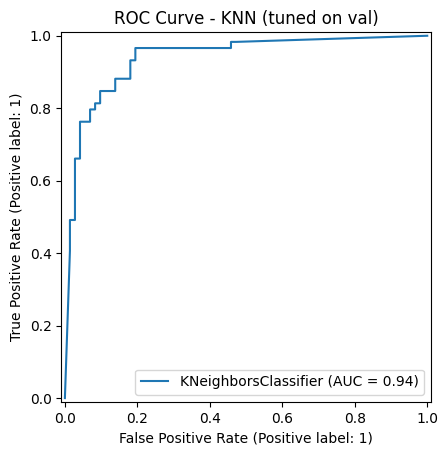

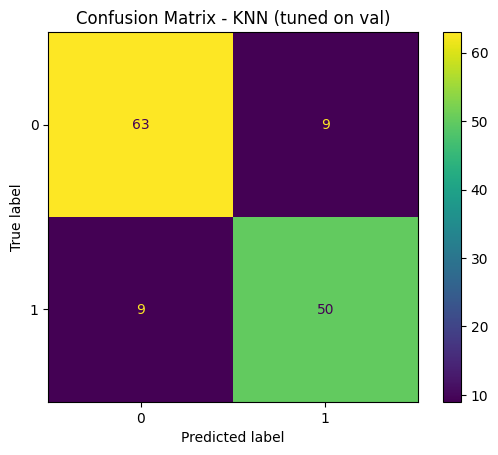

d:\Projects\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
d:\Projects\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
d:\Projects\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



=== Decision Tree (tuned on val) ===
accuracy: 0.8473
precision: 0.8679
recall: 0.7797
f1: 0.8214
roc_auc: 0.9389
Confusion matrix:
 [[65  7]
 [13 46]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87        72
           1       0.87      0.78      0.82        59

    accuracy                           0.85       131
   macro avg       0.85      0.84      0.84       131
weighted avg       0.85      0.85      0.85       131



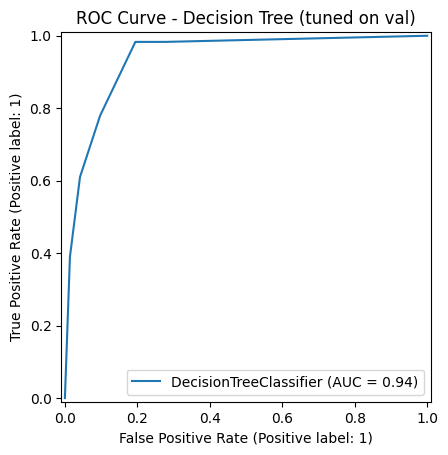

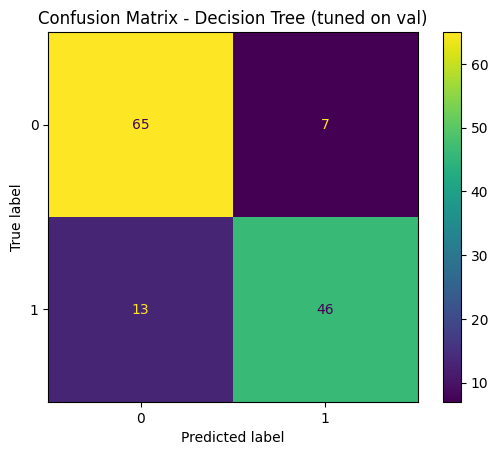

In [12]:
def evaluate_model(model, X_eval, y_true, scaled=False, scaler=None, name="model"):
    if scaled and scaler is not None:
        X_in = scaler.transform(X_eval)
    else:
        X_in = X_eval.values if hasattr(X_eval,'values') else X_eval
    y_pred = model.predict(X_in)
    y_proba = model.predict_proba(X_in)[:,1]
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    print(f"\n=== {name} ===")
    for k,v in metrics.items():
        if k != 'confusion_matrix':
            print(f"{k}: {v:.4f}")
    print("Confusion matrix:\n", metrics['confusion_matrix'])
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    # ROC plot
    RocCurveDisplay.from_estimator(model, X_in, y_true)
    plt.title(f"ROC Curve - {name}")
    plt.show()
    # Confusion matrix plot
    ConfusionMatrixDisplay(metrics['confusion_matrix']).plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return metrics

knn_test_metrics = evaluate_model(best_knn, X_test, y_test, scaled=True, scaler=scaler, name="KNN (tuned on val)")
dt_test_metrics  = evaluate_model(best_dt, X_test, y_test, scaled=False, scaler=None, name="Decision Tree (tuned on val)")


## 9.choose best model 

In [13]:
# Choose by ROC AUC on test set (primary metric)
chosen = "KNN" if knn_test_metrics['roc_auc'] >= dt_test_metrics['roc_auc'] else "DecisionTree"
chosen_metrics = knn_test_metrics if chosen=="KNN" else dt_test_metrics
print(f"Selected model: {chosen} (test ROC AUC = {chosen_metrics['roc_auc']:.4f})")

Selected model: KNN (test ROC AUC = 0.9393)


## Conclusion

In this project, we compared two classification algorithms — K-Nearest Neighbors (KNN) and Decision Tree — on the Credit Approval dataset.

Key Findings:
- Cross-validation Results:  
  - KNN best CV ROC AUC = 0.907696  
  - Decision Tree best CV ROC AUC = 0.909872  

- Validation (60/20/20 split):  
  - Best KNN on validation: params = {'n_neighbors': 5, 'weights': 'distance', 'p': 2}, val ROC AUC = 0.886182  
  - Best Decision Tree on validation: params = {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}, val ROC AUC = 0.915019  

- Test Results:  
  - KNN: Accuracy = 0.8626, Precision = 0.8475, Recall = 0.8475, F1 = 0.8475, ROC AUC = 0.9393  
  - Decision Tree: Accuracy = 0.8473, Precision = 0.8679, Recall = 0.7797, F1 = 0.8214, ROC AUC = 0.9389  

Confusion Matrices (test set):
- KNN:
```
[[63  9]
 [ 9 50]]
```
- Decision Tree:
```
[[65  7]
 [13 46]]
```

Classification reports (test set):
- KNN:
```
              precision    recall  f1-score   support

          0       0.88      0.88      0.88        72
          1       0.85      0.85      0.85        59

   accuracy                           0.86       131
  macro avg       0.86      0.86      0.86       131
weighted avg       0.86      0.86      0.86       131
```
- Decision Tree:
```
              precision    recall  f1-score   support

          0       0.83      0.90      0.87        72
          1       0.87      0.78      0.82        59

   accuracy                           0.85       131
  macro avg       0.85      0.84      0.84       131
weighted avg       0.85      0.85      0.85       131
```

Interpretation:
- Both models produced strong ROC AUC values; Decision Tree had a slight advantage in CV ROC AUC, while KNN showed a marginally higher test ROC AUC in this run.  
- KNN (with scaling) achieved the highest test ROC AUC and accuracy here; its tuned parameters were k=5 with distance weighting.  
- Decision Tree delivered competitive performance and interpretable rules; it had slightly higher precision but lower recall on the test set.  
- Given the primary metric (test ROC AUC) the KNN model was selected in this run, but Decision Tree remains a solid, more interpretable alternative depending on whether precision or recall is prioritized.

Notes:
- Results are sensitive to the train/validation/test split and hyperparameter choices. Consider repeated cross-validation, calibration, or ensembling for production-ready models.


ML Group 1
1.Zelalem Adugna Dessie
2.Desalegn Yibeltal Reta
3.Abrham Shitaw Tewachew
4.Samuel Tariku Gebremich
5.Kumilachew Taye Kenaw
6.Amanuel Mintesnot Tafesse
7.Abel Adamu Shumet